### XGBoost Model for Airline Delay Prediction

Load the libraries

In [17]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,  RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint
from xgboost import XGBClassifier
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
from pandas.errors import DtypeWarning
warnings.filterwarnings("ignore", category=DtypeWarning)

In [22]:
# Create dataframe
airlinedata = pd.read_csv('C:/Greg/MSAI/AAI_510/FINAL/Data/flights.txt')
airlinedata.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Remove rows where the DEPARTURE_DELAY value is missing (NaN)
xgbairlines = airlinedata.dropna(subset=['DEPARTURE_DELAY'])

# Select the categories and the predictors
cats = ['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TAIL_NUMBER']
features = ['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
            'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE', 'DISTANCE']

In [24]:
# Convert delay times to classes
# DEPARTURE_DELAY	    Departure Status
# 0			            On Time
# Negative number (< 0)	Early
# Positive number (> 0)	Delayed
conditions = [
    xgbairlines['DEPARTURE_DELAY'] == 0,
    xgbairlines['DEPARTURE_DELAY'] < 0,
    xgbairlines['DEPARTURE_DELAY'] > 0
]

# Choose the 3 different departure status
choices = ['On Time', 'Early', 'Delayed']

# Convert to the 3 classes
#xgbairlines['DEPARTURE_DELAY'] = np.select(conditions, choices)
xgbairlines.loc[:, 'DEPARTURE_DELAY'] = np.select(conditions, choices)

# Set variables for train/test split
X = xgbairlines[features].copy()
y = xgbairlines['DEPARTURE_DELAY']

# Encode categorical variables
for col in cats:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Convert ['On Time', 'Early', 'Delayed'] to [2, 1, 0]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

C:\Users\gregm\AppData\Local\Temp\ipykernel_18748\2656408247.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['Early' 'Early' 'Early' ... 'Early' 'Early' 'Delayed']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  xgbairlines.loc[:, 'DEPARTURE_DELAY'] = np.select(conditions, choices)


In [25]:
print(y)

0            Early
1            Early
2            Early
3            Early
4            Early
            ...   
5819074      Early
5819075      Early
5819076      Early
5819077      Early
5819078    Delayed
Name: DEPARTURE_DELAY, Length: 5732926, dtype: object


In [26]:
y_encoded

array([1, 1, 1, ..., 1, 1, 0])

In [27]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y)

In [28]:
# Use XGBoost model classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the XGBoost model
xgb.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [30]:
# Evaluation Metrics
# Use trained XGBoost model (xgb) to predict the class labels
y_pred = xgb.predict(X_test)
# Array of predicted class labels (0, 1, 2 for multiclass classification)
y_proba = xgb.predict_proba(X_test)

# Classification report comparing the true labels (y_test) and predicted labels
# Precision: How many predicted positives
# Recall: No. of actual positives predict correctly
# F1-score: Harmonic mean of precision and recall
# Support: No. of true samples for each class
print(classification_report(y_test, y_pred))

# Model ability to distinguish between classes (1.0 = perfect)
print("ROC AUC (ovr):", roc_auc_score(y_test, y_proba, multi_class='ovr'))

              precision    recall  f1-score   support

           0       0.62      0.45      0.52    425124
           1       0.66      0.85      0.74    655590
           2       0.00      0.00      0.00     65872

    accuracy                           0.65   1146586
   macro avg       0.43      0.43      0.42   1146586
weighted avg       0.61      0.65      0.62   1146586

ROC AUC (ovr): 0.6839015004298559


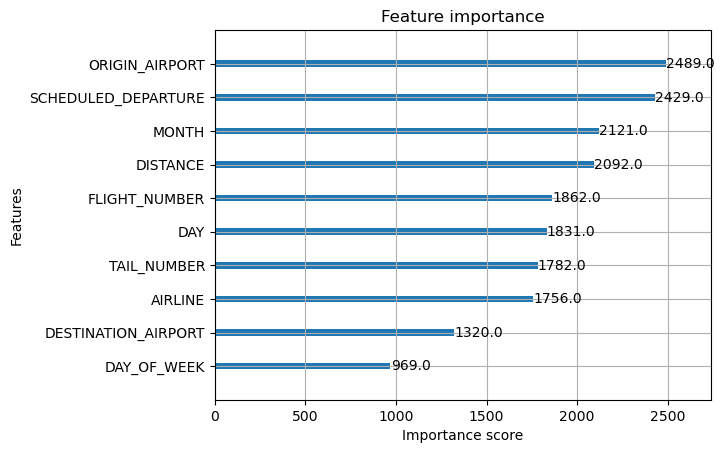

In [29]:
# Feature importance
# Create Bar chart showing importance each feature is in making predictions, based on
# how often and how effectively each feature is used in the decision trees.
import matplotlib.pyplot as plt
import xgboost as xgb_mod
xgb_mod.plot_importance(xgb)
plt.show()